# Multivariate Time Series Forecasting with LSTMs in Keras

Neural networks like Long Short-Term Memory (LSTM) recurrent neural networks are able to almost seamlessly model problems with multiple input variables.

This is a great benefit in time series forecasting, where classical linear methods can be difficult to adapt to multivariate or multiple input forecasting problems.

In this tutorial, you will discover how you can develop an LSTM model for multivariate time series forecasting with the Keras deep learning library.

After completing this tutorial, you will know:

- How to transform a raw dataset into something we can use for time series forecasting.
- How to prepare data and fit an LSTM for a multivariate time series forecasting problem.
- How to make a forecast and rescale the result back into the original units.

# Tutorial Overview

This tutorial is divided into 4 parts; they are:

- Air Pollution Forecasting
- Basic Data Preparation
- Multivariate LSTM Forecast Model
    - LSTM Data Preparation
    - Define and Fit Model
    - Evaluate Model
    - Complete Example
- Train On Multiple Lag Timesteps Example


# 1. Air Pollution Forecasting

In this tutorial, we are going to use the Air Quality dataset.

This is a dataset that reports on the weather and the level of pollution each hour for five years at the US embassy in Beijing, China.

The data includes the date-time, the pollution called PM2.5 concentration, and the weather information including dew point, temperature, pressure, wind direction, wind speed and the cumulative number of hours of snow and rain. The complete feature list in the raw data is as follows:

- No: row number
- year: year of data in this row
- month: month of data in this row
- day: day of data in this row
- hour: hour of data in this row
- pm2.5: PM2.5 concentration
- DEWP: Dew Point
- TEMP: Temperature
- PRES: Pressure
- cbwd: Combined wind direction
- Iws: Cumulated wind speed
- Is: Cumulated hours of snow
- Ir: Cumulated hours of rain

We can use this data and frame a forecasting problem where, given the weather conditions and pollution for prior hours, we forecast the pollution at the next hour.

This dataset can be used to frame other forecasting problems.
Do you have good ideas? Let me know in the comments below.

You can download the dataset from the UCI Machine Learning Repository.

# 2. Basic Data Preparation

The data is not ready to use. We must prepare it first.
The first step is to consolidate the date-time information into a single date-time so that we can use it as an index in Pandas.

A quick check reveals NA values for pm2.5 for the first 24 hours. We will, therefore, need to remove the first row of data. There are also a few scattered “NA” values later in the dataset; we can mark them with 0 values for now.

The script below loads the raw dataset and parses the date-time information as the Pandas DataFrame index. The “No” column is dropped and then clearer names are specified for each column. Finally, the NA values are replaced with “0” values and the first 24 hours are removed.

The “No” column is dropped and then clearer names are specified for each column. Finally, the NA values are replaced with “0” values and the first 24 hours are removed.

In [11]:
from pandas import read_csv
from datetime import datetime
# load data
def parse(x):
	return datetime.strptime(x, '%Y %m %d %H')
dataset = read_csv('raw.csv',  parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse)
dataset.drop('No', axis=1, inplace=True)
# manually specify column names
dataset.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
dataset.index.name = 'date'
# mark all NA values with 0
dataset['pollution'].fillna(0, inplace=True)
# drop the first 24 hours
dataset = dataset[24:]
# summarize first 5 rows
print(dataset.head(5))
# save to file
dataset.to_csv('pollution.csv')

C:\Users\floiu\AppData\Local\Temp\ipykernel_64664\1621407772.py:6: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  dataset = read_csv('raw.csv',  parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse)
C:\Users\floiu\AppData\Local\Temp\ipykernel_64664\1621407772.py:6: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  dataset = read_csv('raw.csv',  parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse)


                     pollution  dew  temp   press wnd_dir  wnd_spd  snow  rain
date                                                                          
2010-01-02 00:00:00      129.0  -16  -4.0  1020.0      SE     1.79     0     0
2010-01-02 01:00:00      148.0  -15  -4.0  1020.0      SE     2.68     0     0
2010-01-02 02:00:00      159.0  -11  -5.0  1021.0      SE     3.57     0     0
2010-01-02 03:00:00      181.0   -7  -5.0  1022.0      SE     5.36     1     0
2010-01-02 04:00:00      138.0   -7  -5.0  1022.0      SE     6.25     2     0


C:\Users\floiu\AppData\Local\Temp\ipykernel_64664\1621407772.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dataset['pollution'].fillna(0, inplace=True)


Now that we have the data in an easy-to-use form, we can create a quick plot of each series and see what we have.

The code below loads the new “pollution.csv” file and plots each series as a separate subplot, except wind speed dir, which is categorical.

Running the example creates a plot with 7 subplots showing the 5 years of data for each variable.

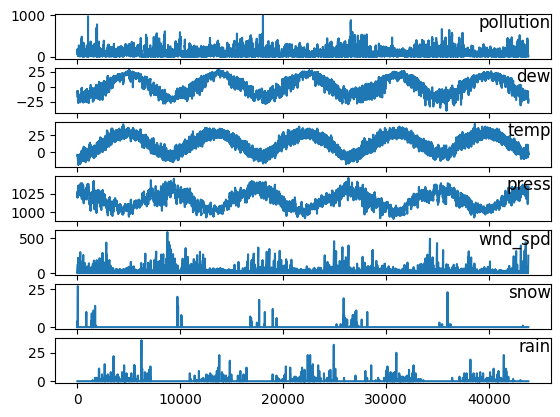

In [14]:
from pandas import read_csv
from matplotlib import pyplot
# load dataset
dataset = read_csv('pollution.csv', header=0, index_col=0)
values = dataset.values
# specify columns to plot
groups = [0, 1, 2, 3, 5, 6, 7]
i = 1
# plot each column
pyplot.figure()
for group in groups:
	pyplot.subplot(len(groups), 1, i)
	pyplot.plot(values[:, group])
	pyplot.title(dataset.columns[group], y=0.5, loc='right')
	i += 1
pyplot.show()

# 3. Multivariate LSTM Forecast Model

In this section, we will fit an LSTM to the problem.

## LSTM Data Preparation

The first step is to prepare the pollution dataset for the LSTM.

This involves framing the dataset as a supervised learning problem and normalizing the input variables.

We will frame the supervised learning problem as predicting the pollution at the current hour (t) given the pollution measurement and weather conditions at the prior time step.

This formulation is straightforward and just for this demonstration. Some alternate formulations you could explore include:

Predict the pollution for the next hour based on the weather conditions and pollution over the last 24 hours.
Predict the pollution for the next hour as above and given the “expected” weather conditions for the next hour.
We can transform the dataset using the series_to_supervised() function developed in the blog post:

https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/

First, the “pollution.csv” dataset is loaded. The wind direction feature is label encoded (integer encoded). This could further be one-hot encoded in the future if you are interested in exploring it.

Next, all features are normalized, then the dataset is transformed into a supervised learning problem. The weather variables for the hour to be predicted (t) are then removed.

The complete code listing is provided below.

In [21]:
# prepare data for lstm
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
 
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
 
# load dataset
dataset = read_csv('pollution.csv', header=0, index_col=0)
values = dataset.values
# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.129779   0.352941   0.245902   0.527273   0.666667   0.002290   
2   0.148893   0.367647   0.245902   0.527273   0.666667   0.003811   
3   0.159960   0.426471   0.229508   0.545454   0.666667   0.005332   
4   0.182093   0.485294   0.229508   0.563637   0.666667   0.008391   
5   0.138833   0.485294   0.229508   0.563637   0.666667   0.009912   

   var7(t-1)  var8(t-1)   var1(t)  
1   0.000000        0.0  0.148893  
2   0.000000        0.0  0.159960  
3   0.000000        0.0  0.182093  
4   0.037037        0.0  0.138833  
5   0.074074        0.0  0.109658  


Running the example prints the first 5 rows of the transformed dataset. We can see the 8 input variables (input series) and the 1 output variable (pollution level at the current hour).

This data preparation is simple and there is more we could explore. Some ideas you could look at include:

- One-hot encoding wind direction.
- Making all series stationary with differencing and seasonal adjustment.
- Providing more than 1 hour of input time steps.

This last point is perhaps the most important given the use of Backpropagation through time by LSTMs when learning sequence prediction problems.

## Define and Fit Model

In this section, we will fit an LSTM on the multivariate input data.

First, we must split the prepared dataset into train and test sets. To speed up the training of the model for this demonstration, we will only fit the model on the first year of data, then evaluate it on the remaining 4 years of data. If you have time, consider exploring the inverted version of this test harness.

The example below splits the dataset into train and test sets, then splits the train and test sets into input and output variables. Finally, the inputs (X) are reshaped into the 3D format expected by LSTMs, namely [samples, timesteps, features].

...
# split into train and test sets
values = reframed.values
n_train_hours = 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

Running this example prints the shape of the train and test input and output sets with about 9K hours of data for training and about 35K hours for testing.

(8760, 1, 8) (8760,) (35039, 1, 8) (35039,)

Now we can define and fit our LSTM model.

We will define the LSTM with 50 neurons in the first hidden layer and 1 neuron in the output layer for predicting pollution. The input shape will be 1 time step with 8 features.

We will use the Mean Absolute Error (MAE) loss function and the efficient Adam version of stochastic gradient descent.

The model will be fit for 50 training epochs with a batch size of 72. Remember that the internal state of the LSTM in Keras is reset at the end of each batch, so an internal state that is a function of a number of days may be helpful (try testing this).

Finally, we keep track of both the training and test loss during training by setting the validation_data argument in the fit() function. At the end of the run both the training and test loss are plotted.

...
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

## Evaluate Model

After the model is fit, we can forecast for the entire test dataset.

We combine the forecast with the test dataset and invert the scaling. We also invert scaling on the test dataset with the expected pollution numbers.

With forecasts and actual values in their original scale, we can then calculate an error score for the model. In this case, we calculate the Root Mean Squared Error (RMSE) that gives error in the same units as the variable itself.

...
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

## Complete Example

The complete example is listed below.

NOTE: This example assumes you have prepared the data correctly, e.g. converted the downloaded “raw.csv” to the prepared “pollution.csv“. See the first part of this tutorial.

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.129779   0.352941   0.245902   0.527273   0.666667   0.002290   
2   0.148893   0.367647   0.245902   0.527273   0.666667   0.003811   
3   0.159960   0.426471   0.229508   0.545454   0.666667   0.005332   
4   0.182093   0.485294   0.229508   0.563637   0.666667   0.008391   
5   0.138833   0.485294   0.229508   0.563637   0.666667   0.009912   

   var7(t-1)  var8(t-1)   var1(t)  
1   0.000000        0.0  0.148893  
2   0.000000        0.0  0.159960  
3   0.000000        0.0  0.182093  
4   0.037037        0.0  0.138833  
5   0.074074        0.0  0.109658  
(8760, 1, 8) (8760,) (35039, 1, 8) (35039,)
Epoch 1/50
122/122 - 3s - loss: 0.0538 - val_loss: 0.0595 - 3s/epoch - 27ms/step
Epoch 2/50
122/122 - 1s - loss: 0.0362 - val_loss: 0.0628 - 863ms/epoch - 7ms/step
Epoch 3/50
122/122 - 1s - loss: 0.0227 - val_loss: 0.0530 - 915ms/epoch - 8ms/step
Epoch 4/50
122/122 - 1s - loss: 0.0185 - val_loss: 0.0520 - 995ms/

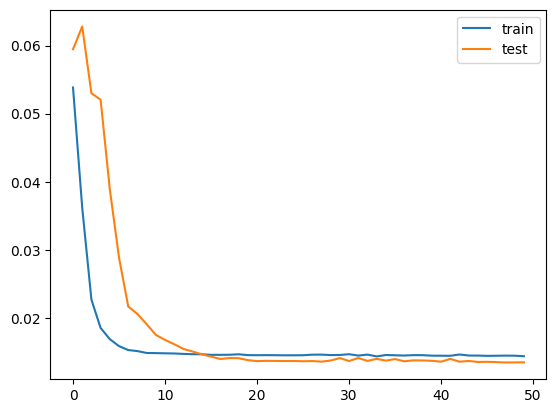

1095/1095 [==============================] - 3s 2ms/step
Test RMSE: 26.466


In [34]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
 
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
 
# load dataset
dataset = read_csv('pollution.csv', header=0, index_col=0)
values = dataset.values
# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
print(reframed.head())
 
# split into train and test sets
values = reframed.values
n_train_hours = 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
 
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()
 
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Running the example first creates a plot showing the train and test loss during training.

Note: Your results may vary given the stochastic nature of the algorithm or evaluation procedure, or differences in numerical precision. Consider running the example a few times and compare the average outcome.

Interestingly, we can see that test loss drops below training loss. The model may be overfitting the training data. Measuring and plotting RMSE during training may shed more light on this.

The Train and test loss are printed at the end of each training epoch. At the end of the run, the final RMSE of the model on the test dataset is printed.

We can see that the model achieves a respectable RMSE of 26.496, which is lower than an RMSE of 30 found with a persistence model.

...
Epoch 46/50
0s - loss: 0.0143 - val_loss: 0.0133
Epoch 47/50
0s - loss: 0.0143 - val_loss: 0.0133
Epoch 48/50
0s - loss: 0.0144 - val_loss: 0.0133
Epoch 49/50
0s - loss: 0.0143 - val_loss: 0.0133
Epoch 50/50
0s - loss: 0.0144 - val_loss: 0.0133
Test RMSE: 26.496

## Train On Multiple Lag Timesteps Example

There have been many requests for advice on how to adapt the above example to train the model on multiple previous time steps.

I had tried this and a myriad of other configurations when writing the original post and decided not to include them because they did not lift model skill.

Nevertheless, I have included this example below as reference template that you could adapt for your own problems.

The changes needed to train the model on multiple previous time steps are quite minimal, as follows:

First, you must frame the problem suitably when calling series_to_supervised(). We will use 3 hours of data as input. Also note, we no longer explictly drop the columns from all of the other fields at ob(t).

...
# specify the number of lag hours
n_hours = 3
n_features = 8
# frame as supervised learning
reframed = series_to_supervised(scaled, n_hours, 1)

Next, we need to be more careful in specifying the column for input and output.

We have 3 * 8 + 8 columns in our framed dataset. We will take 3 * 8 or 24 columns as input for the obs of all features across the previous 3 hours. We will take just the pollution variable as output at the following hour, as follows:

...
# split into input and outputs
n_obs = n_hours * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]
print(train_X.shape, len(train_X), train_y.shape)

Next, we can reshape our input data correctly to reflect the time steps and features.

...
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))

Fitting the model is the same.

The only other small change is in how to evaluate the model. Specifically, in how we reconstruct the rows with 8 columns suitable for reversing the scaling operation to get the y and yhat back into the original scale so that we can calculate the RMSE.

The gist of the change is that we concatenate the y or yhat column with the last 7 features of the test dataset in order to inverse the scaling, as follows:

...
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, -7:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -7:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

We can tie all of these modifications to the above example together. The complete example of multvariate time series forecasting with multiple lag inputs is listed below:

(43797, 32)
(8760, 24) 8760 (8760,)
(8760, 3, 8) (8760,) (35037, 3, 8) (35037,)
Epoch 1/50
122/122 - 2s - loss: 0.0511 - val_loss: 0.0602 - 2s/epoch - 15ms/step
Epoch 2/50
122/122 - 1s - loss: 0.0266 - val_loss: 0.0305 - 689ms/epoch - 6ms/step
Epoch 3/50
122/122 - 1s - loss: 0.0217 - val_loss: 0.0215 - 752ms/epoch - 6ms/step
Epoch 4/50
122/122 - 1s - loss: 0.0211 - val_loss: 0.0198 - 774ms/epoch - 6ms/step
Epoch 5/50
122/122 - 1s - loss: 0.0207 - val_loss: 0.0199 - 717ms/epoch - 6ms/step
Epoch 6/50
122/122 - 1s - loss: 0.0205 - val_loss: 0.0189 - 868ms/epoch - 7ms/step
Epoch 7/50
122/122 - 1s - loss: 0.0198 - val_loss: 0.0182 - 1s/epoch - 8ms/step
Epoch 8/50
122/122 - 1s - loss: 0.0195 - val_loss: 0.0181 - 1s/epoch - 9ms/step
Epoch 9/50
122/122 - 1s - loss: 0.0189 - val_loss: 0.0176 - 1s/epoch - 11ms/step
Epoch 10/50
122/122 - 1s - loss: 0.0185 - val_loss: 0.0174 - 1s/epoch - 10ms/step
Epoch 11/50
122/122 - 1s - loss: 0.0181 - val_loss: 0.0170 - 1s/epoch - 9ms/step
Epoch 12/50
122/122 

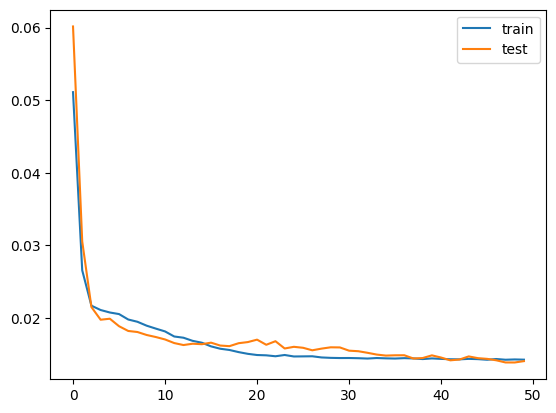

1095/1095 [==============================] - 3s 3ms/step
Test RMSE: 26.521


In [47]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
 
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
 
# load dataset
dataset = read_csv('pollution.csv', header=0, index_col=0)
values = dataset.values
# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# specify the number of lag hours
n_hours = 3
n_features = 8
# frame as supervised learning
reframed = series_to_supervised(scaled, n_hours, 1)
print(reframed.shape)
 
# split into train and test sets
values = reframed.values
n_train_hours = 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
n_obs = n_hours * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]
print(train_X.shape, len(train_X), train_y.shape)
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
 
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()
 
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_hours*n_features))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, -7:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -7:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Note: Your results may vary given the stochastic nature of the algorithm or evaluation procedure, or differences in numerical precision. Consider running the example a few times and compare the average outcome.

The model is fit as before in a minute or two.

...
Epoch 45/50
1s - loss: 0.0143 - val_loss: 0.0154
Epoch 46/50
1s - loss: 0.0143 - val_loss: 0.0148
Epoch 47/50
1s - loss: 0.0143 - val_loss: 0.0152
Epoch 48/50
1s - loss: 0.0143 - val_loss: 0.0151
Epoch 49/50
1s - loss: 0.0143 - val_loss: 0.0152
Epoch 50/50
1s - loss: 0.0144 - val_loss: 0.0149

A plot of train and test loss over the epochs is plotted.
Finally, the Test RMSE is printed, not really showing any advantage in skill, at least on this problem.
I would add that the LSTM does not appear to be suitable for autoregression type problems and that you may be better off exploring an MLP with a large window.

I hope this example helps you with your own time series forecasting experiments.

# Summary

In this tutorial, you discovered how to fit an LSTM to a multivariate time series forecasting problem.

Specifically, you learned:

- How to transform a raw dataset into something we can use for time series forecasting.
- How to prepare data and fit an LSTM for a multivariate time series forecasting problem.
- How to make a forecast and rescale the result back into the original units.